# 混合整数計画問題への素朴な数理モデルの実装と実験

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pulp

In [2]:
# 地点データ
df_k_location = pd.read_csv('small_locations.csv')
df_k_location

,k,x,y,depo_flag
0,p,0,0,1
1,s1,-2,0,0
2,s2,-2,-2,0
3,s3,4,0,0
4,s4,4,2,0


- `p` : 配送センター（$p$）
    - `depo_flag` が 1
    - 原点(0, 0)
- お店は `s1` ～ `s4`（$S= \lbrace s1, s2, ･･･ \rbrace$）
- `k`: 地点（$K= \lbrace p, s1, s2, ... \rbrace$）

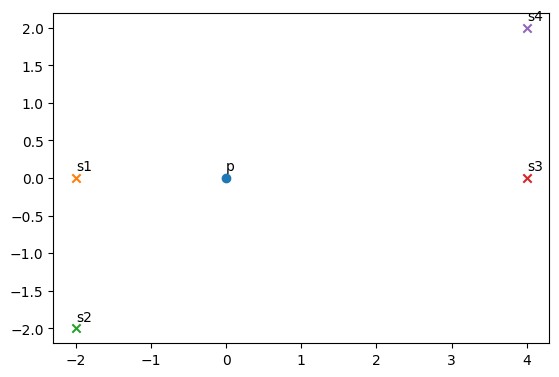

In [3]:
# 可視化
fig, ax = plt.subplots()
ax.set_aspect('equal')
for row in df_k_location.itertuples():
    if row.depo_flag:
        ax.scatter(row.x, row.y, marker='o')
    else:
        ax.scatter(row.x, row.y, marker='x')
    ax.annotate(row.k, (row.x, row.y + 0.1))
plt.show()

In [4]:
# 移動時間データ
df_kk_distance = pd.read_csv('small_distances.csv')
df_kk_distance

,k1,k2,t
0,p,p,0.000000
1,p,s1,2.000000
2,p,s2,2.828427
3,p,s3,4.000000
4,p,s4,4.472136
5,s1,p,2.000000
6,s1,s1,0.000000
7,s1,s2,2.000000
8,s1,s3,6.000000
9,s1,s4,6.324555


`t`: `k1` から `k2` への移動時間（$t_{k1, k2} \in \mathbb{R}_{\geq 0} \quad (k1, k2 \in K)$）

In [5]:
# 荷物データ
df_r_order = pd.read_csv('small_orders.csv')
df_r_order

,r,s,w,b,e
0,r1,s1,1000,1,1
1,r2,s2,1000,1,2
2,r3,s3,1000,2,2
3,r4,s4,1500,2,3
4,r5,s1,1500,2,4
5,r6,s2,1500,3,4
6,r7,s3,1500,3,4
7,r8,s4,3000,4,4


- `r` : 荷物（$R= \lbrace r1, r2, ... \rbrace$）
- `s` : 荷物の配送先の店舗（$s_r \in S \quad (r \in R)$）
- `w` : 重量（$ w_r \in \mathbb{R}_{\geq 0} \quad (r \in R) $）
- `b` : 開始日
- `e`: 終了日      
    （$b_r, e_r \in D \quad (r \in R) \quad (D= \lbrace 1, 2, ..., 20 \rbrace)$）

#### 集合

In [6]:
# 配送日のリスト
D = list(range(df_r_order['b'].min(), df_r_order['e'].max() + 1))
D

[1, 2, 3, 4]

$ D = \lbrace 1, 2, ..., 20 \rbrace $

In [7]:
# 配送センター
p = df_k_location.loc[df_k_location['depo_flag'] == 1, 'k'].tolist()[0]
p

'p'

$ p $

In [8]:
# お店のリスト
S = df_k_location.loc[df_k_location['depo_flag'] == 0, 'k'].tolist()
S

['s1', 's2', 's3', 's4']

$ S = \lbrace s1, s2, ... \rbrace $

In [9]:
# 地点のリスト
K = [p] + S
K

['p', 's1', 's2', 's3', 's4']

$ K = \lbrace p, s1, s2, ... \rbrace $

In [10]:
# 荷物のリスト
R = df_r_order['r'].tolist()
R

['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']

$ R = \lbrace r1, r2, ... \rbrace  $

#### 定数

In [11]:
# 荷物に紐づける
R2S = { row.r: row.s for row in df_r_order.itertuples() }
print(R2S)

{'r1': 's1', 'r2': 's2', 'r3': 's3', 'r4': 's4', 'r5': 's1', 'r6': 's2', 'r7': 's3', 'r8': 's4'}


$ S_r \in S \quad (r \in R) $

In [12]:
# 荷物に紐づける重量
R2W = { row.r: row.w for row in df_r_order.itertuples() }
print(R2W)

{'r1': 1000, 'r2': 1000, 'r3': 1000, 'r4': 1500, 'r5': 1500, 'r6': 1500, 'r7': 1500, 'r8': 3000}


$ w_r \in W \quad (r \in R)$

In [13]:
# 荷物に紐づける指定配送期間の開始日
R2B = {row.r: row.b for row in df_r_order.itertuples()}
print(R2B)

{'r1': 1, 'r2': 1, 'r3': 2, 'r4': 2, 'r5': 2, 'r6': 3, 'r7': 3, 'r8': 4}


$ b_r \in D \quad (r \in R) $

In [14]:
# 荷物に紐づける指定配送期間の終了日
R2E = {row.r: row.e  for row in df_r_order.itertuples()}
print(R2E)

{'r1': 1, 'r2': 2, 'r3': 2, 'r4': 3, 'r5': 4, 'r6': 4, 'r7': 4, 'r8': 4}


$ e_r \in D \quad (r \in R) $

In [15]:
# 地点間の移動時間
KK2T = {(row.k1, row.k2): row.t for row in df_kk_distance.itertuples()}
print(KK2T)

{('p', 'p'): 0.0, ('p', 's1'): 2.0, ('p', 's2'): 2.8284271247461903, ('p', 's3'): 4.0, ('p', 's4'): 4.47213595499958, ('s1', 'p'): 2.0, ('s1', 's1'): 0.0, ('s1', 's2'): 2.0, ('s1', 's3'): 6.0, ('s1', 's4'): 6.324555320336759, ('s2', 'p'): 2.8284271247461903, ('s2', 's1'): 2.0, ('s2', 's2'): 0.0, ('s2', 's3'): 6.324555320336759, ('s2', 's4'): 7.211102550927978, ('s3', 'p'): 4.0, ('s3', 's1'): 6.0, ('s3', 's2'): 6.324555320336759, ('s3', 's3'): 0.0, ('s3', 's4'): 2.0, ('s4', 'p'): 4.47213595499958, ('s4', 's1'): 6.324555320336759, ('s4', 's2'): 7.211102550927978, ('s4', 's3'): 2.0, ('s4', 's4'): 0.0}


$ t_{k1,k2} \in \mathbb{R}_{\geq 0} \quad (k1, k2 \in K)$

## 実装

In [16]:
prob = pulp.LpProblem('vrp_small', pulp.LpMinimize)  # 配送費用（残業費用 + 外注費用）の最小化

In [ ]:
# 地点間の移動の有無
